In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Reading from NY2 dataset
dataset_file = "C:\\Users\\Avell\\Desktop\\ITA\\Tese mestrado\\SegmentationDataset\\dataset.mat"; # Windows

f = h5py.File(dataset_file,'r')
images = np.array(f.get('images')).T
labels = np.array(f.get('labels')).T
print(images.shape)
print(labels.shape)

(480, 640, 3, 1449)
(480, 640, 1449)


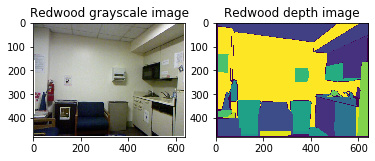

In [3]:
plt.subplot(2, 2, 1)
plt.title('RGB')
plt.imshow(images[:,:,:,0])
plt.subplot(2, 2, 2)
plt.title('Labels')
plt.imshow(labels[:,:,0])
plt.subplot(2, 2, 3)
plt.title('RGB')
plt.imshow(images[:,:,:,4])
plt.subplot(2, 2, 3)
plt.title('Labels')
plt.imshow(labels[:,:,4])
plt.show()

